In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

from sde.sde_learning_network import \
    (
        SDEIdentification,
        ModelBuilder,
        SDEApproximationNetwork,
    )

from sde.experiment_reports import \
(
    sample_data,
    plot_results_functions,
    generate_results,
    plot_results_1d
)

%load_ext autoreload
%autoreload 2

In [2]:
# notebook parameters
random_seed = 1
step_size = .25  # step size
n_pts = 20000     # number of points

n_layers = 2
n_dim_per_layer = 50

n_dimensions = 3

ACTIVATIONS = tf.nn.leaky_relu
VALIDATION_SPLIT = .1
BATCH_SIZE = 32
N_EPOCHS = 100

xlim = [-.3, .3]

# full covariance matrix, here SPD type
diffusivity_type = "spd"

tf.random.set_seed(random_seed)

In [3]:
# EXAMPLE 2

true_diffusivity_matrix = np.array([[1, 0, 0], [-5, 2, 0], [1, 0, 1]]) * 1e-1

rng = np.random.default_rng(1)
true_diffusivity_matrix = rng.uniform(low=xlim[0], high=xlim[1], size=(n_dimensions, n_dimensions)) * np.tri(n_dimensions)
diag_tri = np.diag(np.diag(true_diffusivity_matrix))
true_diffusivity_matrix = true_diffusivity_matrix - diag_tri + np.abs(diag_tri)

# make SPD
true_diffusivity_matrix = true_diffusivity_matrix @ true_diffusivity_matrix.T

print(true_diffusivity_matrix)


def true_drift(x):
    return -x


def true_diffusivity(x):
    """
    This diffusivity is not differentiable (absolute value of x),
    so we need relu activations.
    """
    shift = true_diffusivity_matrix
    x = 0*x

    if x.shape[0] == 1:
        return shift
    else:
        return np.repeat(shift[np.newaxis, ...], x.shape[0], axis=0)


def true_drift_diffusivity(x):
    return true_drift(x), true_diffusivity(x)


rng = np.random.default_rng(random_seed)

x_data, y_data = sample_data(true_drift_diffusivity,
                             step_size=step_size, n_dimensions=n_dimensions,
                             low=-1, high=1, n_pts=n_pts,
                             rng=rng)
x_data_test, y_data_test = sample_data(true_drift_diffusivity,
                                       step_size=step_size,
                                       n_dimensions=n_dimensions,
                                       low=-1, high=1,
                                       n_pts=n_pts//10, rng=rng)
print('data shape', x_data.shape)

step_sizes = np.zeros((x_data.shape[0],)) + step_size

[[5.03102918e-05 1.90935554e-03 1.39463175e-03]
 [1.90935554e-03 8.52097424e-02 4.67775795e-02]
 [1.39463175e-03 4.67775795e-02 4.25135954e-02]]
data shape (20000, 3)


In [4]:
# define the neural network model we will use for identification
encoder = ModelBuilder.define_gaussian_process(
                                        n_input_dimensions=n_dimensions,
                                        n_output_dimensions=n_dimensions,
                                        n_layers=n_layers,
                                        n_dim_per_layer=n_dim_per_layer,
                                        name="GP",
                                        activation=ACTIVATIONS,
                                        diffusivity_type=diffusivity_type)
encoder.summary()

model = SDEApproximationNetwork(sde_model=encoder,
                                method="euler",
                                diffusivity_type=diffusivity_type)

model.compile(optimizer=tf.keras.optimizers.Adamax())

sde_i = SDEIdentification(model=model)

Model: "GP_gaussian_process"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
GP_inputs (InputLayer)          [(None, 3)]          0                                            
__________________________________________________________________________________________________
GP_std_hidden_0 (Dense)         (None, 50)           200         GP_inputs[0][0]                  
__________________________________________________________________________________________________
GP_mean_hidden_0 (Dense)        (None, 50)           200         GP_inputs[0][0]                  
__________________________________________________________________________________________________
GP_std_hidden_1 (Dense)         (None, 50)           2550        GP_std_hidden_0[0][0]            
________________________________________________________________________________

training for 100 epochs with 18000 data points, validating with 2000
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
The average loss for epoch 99 is -11.9624780870     

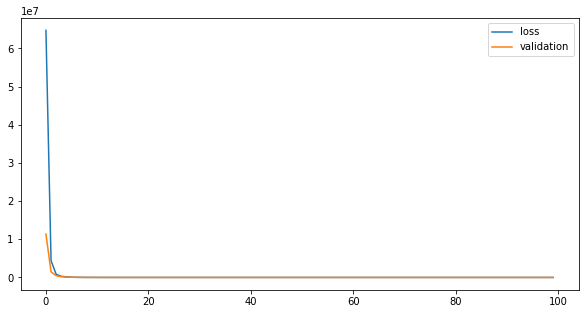

In [5]:
hist = sde_i.train_model(x_data, y_data, step_size=step_sizes,
                         validation_split=VALIDATION_SPLIT,
                         n_epochs=N_EPOCHS,
                         batch_size=BATCH_SIZE)

fig, hist_axes = plt.subplots(1, 1, figsize=(10, 5))
hist_axes.clear()
hist_axes.plot(hist.history["loss"], label='loss')
hist_axes.plot(hist.history["val_loss"], label='validation')
hist_axes.legend()

In [6]:
print(f"Training loss final: {hist.history['loss'][-1]}")
print(f"Validation loss final: {hist.history['val_loss'][-1]}")

Training loss final: -11.962478087038747
Validation loss final: -12.055050674754495


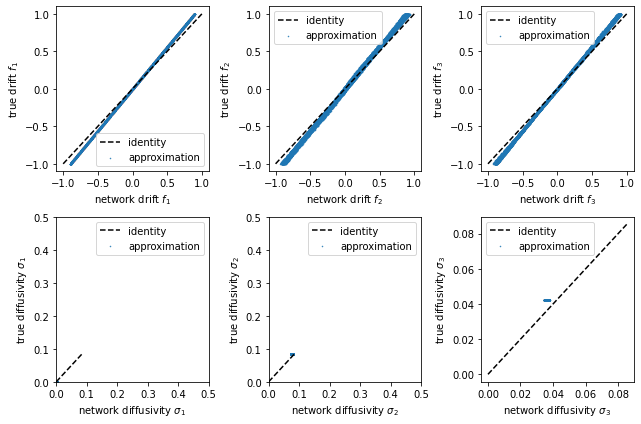

In [7]:
rng = np.random.default_rng(random_seed)

ax = plot_results_functions(sde_i.drift_diffusivity, true_drift_diffusivity,
                            x_data, y_data, rng,
                            data_transform_network=None,
                            data_transform_true=None)

for k in range(2):
    ax[1, k].set_xlim([0, .5])
    ax[1, k].set_ylim([0, .5])

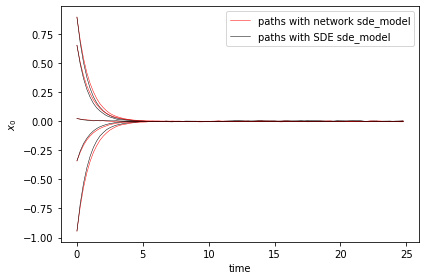

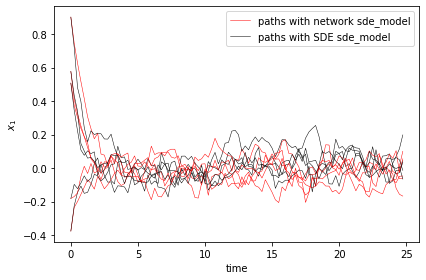

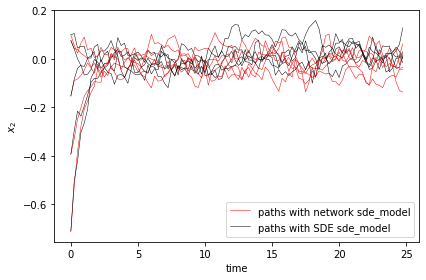

In [8]:
T_steps = 100
N_iterates = 5

rng = np.random.default_rng(random_seed)

time_steps, paths_network = \
    generate_results(sde_i.drift_diffusivity,
                     step_size, x_data, rng,
                     T_steps=T_steps, N_iterates=N_iterates);

time_steps, paths_true = \
    generate_results(true_drift_diffusivity,
                     step_size, x_data, rng,
                     T_steps=T_steps, N_iterates=N_iterates);

for k in range(n_dimensions):
    plot_results_1d(time_steps, paths_network, paths_true, plot_dim=k, linewidth=.5);
    plt.gca().set_ylabel(fr"$x_{k}$");

[[0.00051161 0.00171289 0.00131282]
 [0.00171289 0.07605882 0.04110096]
 [0.00131282 0.04110096 0.03660936]]
(3, 3)
[[2.35487953e-05 7.83121662e-06 3.33019149e-06]
 [7.83121662e-06 3.96031518e-04 1.79625152e-04]
 [3.33019149e-06 1.79625152e-04 1.24797038e-04]]


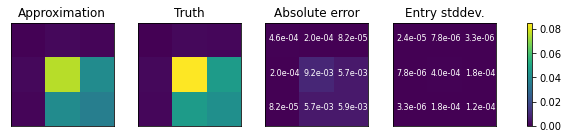

network_diffusivity_matrix
[[0.00051161 0.00171289 0.00131282]
 [0.00171289 0.07605882 0.04110096]
 [0.00131282 0.04110096 0.03660936]]
true_diffusivity_matrix
[[5.03102918e-05 1.90935554e-03 1.39463175e-03]
 [1.90935554e-03 8.52097424e-02 4.67775795e-02]
 [1.39463175e-03 4.67775795e-02 4.25135954e-02]]
error
[[4.61304599e-04 1.96464395e-04 8.18090947e-05]
 [1.96464395e-04 9.15092364e-03 5.67661725e-03]
 [8.18090947e-05 5.67661725e-03 5.90423064e-03]]


In [9]:
rng = np.random.default_rng(1)

sks = []
for k in range(1000):
    x0 = rng.uniform(low=xlim[0], high=xlim[1], size=(1,n_dimensions))
    _, sk = model.call_xn(x0)

    if np.prod(sk.shape) > np.prod(x0.shape):
        sk = tf.keras.backend.eval(tf.reshape(sk, (n_dimensions, n_dimensions)))
    else:
        sk = np.diag(tf.keras.backend.eval(sk)[0])
    sks.append(sk)
sk = np.mean(sks, axis=0)
skstd = np.std(sks, axis=0)

print(sk)

vlim = [np.min([np.min(sk), np.min(true_diffusivity_matrix)]), np.max([np.max(sk), np.max(true_diffusivity_matrix)])]
vlim[0] = 0

abserror = np.abs(sk-true_diffusivity_matrix)

print(abserror.shape)
print(skstd)

cmap = "viridis"
fig, ax = plt.subplots(1, 4, figsize=(9, 2))
ax[0].imshow(sk, vmin=vlim[0], vmax=vlim[1], cmap=cmap)
ax[0].set_title("Approximation")
ax[1].imshow(true_diffusivity_matrix, vmin=vlim[0], vmax=vlim[1], cmap=cmap)
ax[1].set_title("Truth")
ax[2].imshow(abserror, vmin=vlim[0], vmax=vlim[1],  cmap=cmap)
ax[2].set_title("Absolute error")
sc=ax[3].imshow(skstd, vmin=vlim[0], vmax=vlim[1],  cmap=cmap)
ax[3].set_title("Entry stddev.")

for k1 in range(3):
    for k2 in range(3):
        if abserror[k2, k1] > 0:
            ax[2].text(k1-.4, k2+.025, f"{abserror[k2, k1]:.1e}", color="white", fontsize=8)
        else:
            ax[2].text(k1-.15, k2+.025, f"0.0", color="white", fontsize=8)
        if skstd[k2, k1] > 0:
            ax[3].text(k1-.4, k2+.025, f"{skstd[k2, k1]:.1e}", color="white", fontsize=8)
        else:
            ax[3].text(k1-.15, k2+.025, f"0.0", color="white", fontsize=8)

for k in range(4):
    ax[k].set_xticks([])
    ax[k].set_yticks([])
fig.tight_layout()
fig.colorbar(sc, ax=fig.get_axes())

plt.show()
print("network_diffusivity_matrix")
print(sk)
print("true_diffusivity_matrix")
print(true_diffusivity_matrix)
print("error")
print(abserror)

fig.savefig("figures/example_3dfull_matrixcompare.pdf")
fig.savefig("figures/example_3dfull_matrixcompare.png")